# Détection du churn - opérateur Télécom
## _Partie 2_

## Objectif
Dans la première partie, nous avons appris les notions de classification binaires et avons entraîné un premier modèle.

Dans cette seconde partie, nous nous attarderons un peu plus sur la validation du modèle et l'analyse de ses performances. Nous verrons 2 notions fondamentales que sont le sur-apprentissage (*overfitting*) et le sous-apprentissage (*underfitting*).

#### Les sujets abordés : 

* Séparation *trainset* / *testset*
* Sur-apprentissage / sous-apprentissage
* k-fold cross-validation 
* Hyper-paramètres d'un modèles
* Hyper-optimisation

#### Contexte
Voir partie 1.

## Chargement des données

Pour cette partie, on reprend simplement le code du notebook précédent.

In [1]:
import pandas as pd

In [2]:
# This function will be used below
def transform_to_binary(val):
    """
    val is equal to "Yes" or "No"
    This function should return 0 or 1
    """
    return int(val == "Yes")

In [3]:
# Change here if needed
dataset_path = "./datasets/TelcoChurnDetection/telecom_users.csv"

# Read the data
dataset = pd.read_csv(dataset_path, index_col=0)

# features
categorical_features = ["Dependents", "Partner", "SeniorCitizen", 'Churn']
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]
dataset = dataset[categorical_features+numerical_features].copy()

# Converting
dataset.TotalCharges = pd.to_numeric(dataset.TotalCharges, errors='coerce').fillna(0)
for feature in categorical_features:
    dataset[feature] = dataset[feature].apply(transform_to_binary)


dataset

,Dependents,Partner,SeniorCitizen,Churn,tenure,MonthlyCharges,TotalCharges
1869,1,1,0,0,72,24.10,1734.65
4528,0,0,0,0,44,88.15,3973.20
6344,0,1,0,1,38,74.95,2869.85
6739,0,0,0,0,4,55.90,238.50
432,0,0,0,0,2,53.45,119.50
...,...,...,...,...,...,...,...
3772,0,1,0,1,1,95.00,95.00
5191,1,1,0,0,23,91.10,2198.30
5226,1,1,0,0,12,21.15,306.05
5390,0,0,0,1,12,99.45,1200.15


## Séparation train / test

Dans le cadre de votre mission, pour élabore un modèle, vous explorez et analyser des données dites "froides" : elles ont été extraites de bases de données à un moment données et ne sont pas mises à jour.

Comment garantir que la précision et le rappel que vous avez mesurés soient identiques sur des données plus récentes ?

Est-ce que le modèle a réellement _appris_ à détecter des signaux de churn, ou est-ce qu'il a appris à partir d'autres motifs, "_par chance_" ?

Afin de répondre à ces questions, la méthode consiste à séparer le dataset en 2 :
* le trainset : c'est le jeu d'entraînement, sur lequel l'algorithme va apprendre à détecter le churn
* le testset : c'est un jeu de test. **Ce jeu n'est pas utilisé pour l'entraînement** mais seulement pour valider les résultats. 

Dans les lignes suivantes, nous allons séparer le dataset en 2 parties puis effectuer cette démarche de validation.

#### Remarque générale : pensez à bien mettre votre code en fonction afin de pouvoir le réutiliser à la fois pour le traiset et le testset.


In [4]:
# Split features and target
X = dataset.drop(["Churn"], axis=1).copy()
y = dataset["Churn"]
X.shape, y.shape

((5986, 6), (5986,))

In [5]:
# Random of split of the dataset : 70/30
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(f"Shape of 'X_train' is: {X_train.shape}")
print(f"Shape of 'X_test' is: {X_test.shape}")
print(f"Shape of 'y_train' is: {y_train.shape}")
print(f"Shape of 'y_test' is: {y_test.shape}")

Shape of 'X_train' is: (4190, 6)
Shape of 'X_test' is: (1796, 6)
Shape of 'y_train' is: (4190,)
Shape of 'y_test' is: (1796,)


In [6]:
# Show proportion of target in each set
churn_rate_train = y_train.mean()
churn_rate_test = y_test.mean()

print(f"Churn Rate in trainset is: {churn_rate_train:.3f}")
print(f"Churn Rate in testset is: {churn_rate_test:.3f}")

Churn Rate in trainset is: 0.263
Churn Rate in testset is: 0.269


In [7]:
# Here, train a DecisionTree
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

model.fit(X_train, y_train)

DecisionTreeClassifier()

In [8]:
# Use the model to compute prediction on both trainset and testset
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [9]:
# compute confusion matrix both on train and test
from sklearn.metrics import confusion_matrix
mat_train = confusion_matrix(y_train, y_train_pred)
mat_test = confusion_matrix(y_test, y_test_pred) 

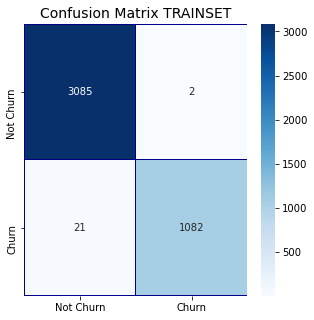

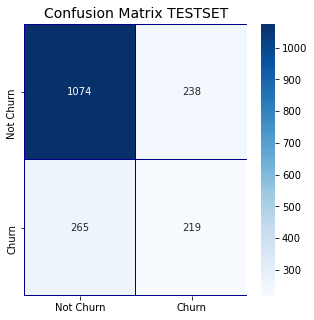

In [10]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

for lab, cm in zip(["TRAINSET", "TESTSET"], [mat_train, mat_test]):
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['Not Churn', 'Churn'],
                yticklabels=['Not Churn', 'Churn'],
                annot=True,ax=ax1,fmt="d",
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    plt.title(f'Confusion Matrix {lab}', fontsize=14)
    plt.show()

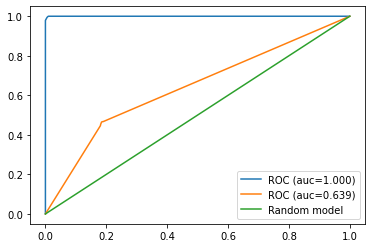

In [11]:
#In order to plot the ROC curve, compute predict socre
from sklearn.metrics import roc_curve, roc_auc_score

y_train_pred = model.predict_proba(X_train)[:,1]
y_test_pred = model.predict_proba(X_test)[:,1]

fpr, tpr, thr = roc_curve(y_train, y_train_pred)
auc = roc_auc_score(y_train, y_train_pred)
plt.plot(fpr, tpr, label=f"ROC (auc={auc:.3f})")

fpr, tpr, thr = roc_curve(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)
plt.plot(fpr, tpr, label=f"ROC (auc={auc:.3f})")

plt.plot([0,1], [0,1], label="Random model")
plt.legend()

### Remarques

L'entraînement avec un arbre de décision simple a tendance à apprendre "trop" sur le jeu d'entraînement, mais les performances sont bien moins bonnes sur le jeu de données de test.

On dit qu'il a _overfitté_ notre dataset.

Pour corriger le problème, on va réduire la complexité du modèle (le nombre paramètres) afin d'obtenir un modèle plus robuste. C'est la capacité de **généralisation** du modèle.

Pour la suite, nous utiliserons des Random Forest et nous essayerons de trouver la profondeur optimale des arbres.


In [12]:
from sklearn.ensemble import RandomForestClassifier

def compute_randomForest_auc(max_depth):
    """
    This function compute the ROC AUC of a RandomForest algorithm
    Input: max_depths : paramter to pass to the algorithm
    Output
    * roc auc on traintest
    * roc auc on testset
    """
    model = RandomForestClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]
    auc_train = roc_auc_score(y_train, y_train_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)
    return (auc_train, auc_test)

%time compute_randomForest_auc(5)

Wall time: 339 ms


(0.8497182493426503, 0.7895435963011489)

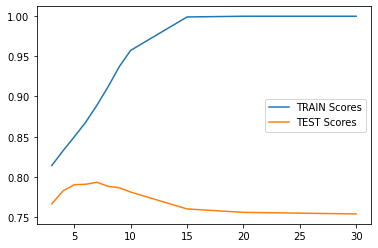

In [13]:
xx = list(range(3,11)) +[15, 20, 30]
train_scores, test_scores = zip(*[compute_randomForest_auc(n) for n in xx])

plt.plot(xx, train_scores, label="TRAIN Scores")
plt.plot(xx, test_scores, label="TEST Scores")
plt.legend()

On observe que plus les arbres sont grands, plus l'écart entre traintest & testset est grande et les modèles vont 'surapprendre".


Un des grands intérêt de l'algorithme RandomForest est qu'il est très robuste au sur-entraînement. En particulier, il est possible de jouer sur différents paramètres comme le nombre d'arbres, et sur des paramètres rendant l'algorithme plus ou moins aléatoires (comme : la quantité de features ou d'observations prises en compte lors de la construction de chaque arbre.)

On appelle ces valeurs des **hyper-paramètres** du modèle (les **paramètres** d'un modèle étant le choix des feautures et les valeurs de seuils dans chaque noeud de l'arbre). Les **hyper-paramètres** contrôle comment l'algorithme apprend à partir des données, c'est à dire comment il génère les **paramètres** du modèle.

dans les cellules suivantes, analyser l'importance des hyper-paramètres suivant : 
* n_estimators
* min_samples_split
* max_features  


In [14]:
def compute_randomForest_auc(max_depth=8, n_estimators=100):
    """
    This function compute the ROC AUC of a RandomForest algorithm
    Input: max_depths : paramter to pass to the algorithm
    Output
    * roc auc on traintest
    * roc auc on testset
    """
    model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
    model.fit(X_train, y_train)
    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]
    auc_train = roc_auc_score(y_train, y_train_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)
    return (auc_train, auc_test)

%time compute_randomForest_auc(n_estimators=100)

Wall time: 478 ms


(0.9123127988837463, 0.7893845431868575)

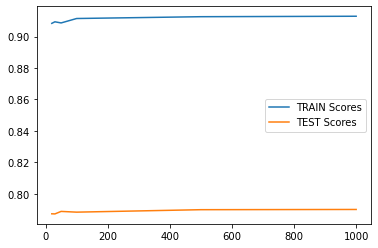

In [15]:
xx = [20, 30, 50, 100, 500, 1000]
train_scores, test_scores = zip(*[compute_randomForest_auc(n_estimators=n) for n in xx])

plt.plot(xx, train_scores, label="TRAIN Scores")
plt.plot(xx, test_scores, label="TEST Scores")
plt.legend()

Dans l'exemple ci-dessus, on observe que pour une profondeur d'arbre fixée à 8, l'influence du nombre d'estimateurs dans l'algorithme RandomForest est très faible.

## K-fold Cross-validation


La validation croisée 'K-Fold' est une technique pour analyser la capacité de **généralisation** d'un modèle, autrement dit sa **variance**.

Dans la section précédente, on a séparé traintest et testset.

Avec la validation croisée K-Fold, le principale est le suivant. Prenons K = 5. On sépare le dataset complet en 5 partie égale.
Alors pour chacune de ces 5 parties ("Fold") : 
* l'entraînement est effectué sur les 4 autres (soit 80% du dataset)
* la validation sur la 5e partie (soit 20% du dataset)

Ce qui fait 5 entraînements / validations.


Cette technique est particulièrement importante si le dataset n'est pas très grand et on suspecte un risque de forte variation entre les entraînements.

Le but de la cellule suivante est d'utiliser cette technique sur notre jeu de données précédent.

#### Que pouvez-vous dire de la stabilité de l'entraînement ?

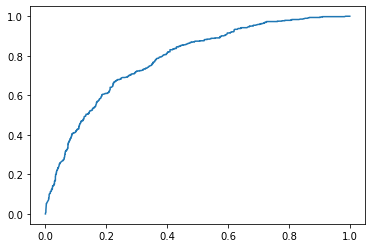

In [16]:
# Here we write a function to help implement K-fold validation
def compute_RF_performance(X_train, y_train, X_test, y_test, **params):
    """
    This function computes performance of RF for given Train/Test set
    X_train/y_train are features and target for trainset
    X_test/y_test are features and target for testset
    params is a set of parameters to pass to the algorithm
    It should plot the ROC Curve on test set
    """
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_test_pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, thr = roc_curve(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_test_pred)
    plt.plot(fpr, tpr, label=f"ROC (auc={auc:.3f})")
    
compute_RF_performance(X_train, y_train, X_test, y_test, n_estimators=50, max_depth=4)

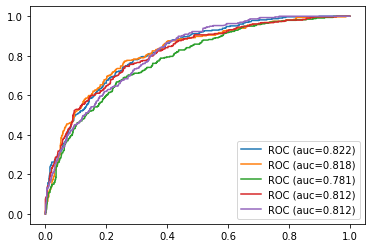

In [17]:
# Here do the actual K-Fold
# Hint : check out doc for dataframe method iloc
from sklearn.model_selection import KFold
²²
cv = KFold(n_splits=5) 
for train, test in cv.split(X):
    compute_RF_performance(X.iloc[train], y.iloc[train], X.iloc[test], y.iloc[test], n_estimators=100, max_depth=4)
    plt.legend()

# Hyper-optimisation du modèle

Dans les dernières sections nous avons vu l'influence des **hyper-paramètres** de l'algorithme sur la performance du modèle.

Naturellement, nous souhaitons optimiser le choix de ces hyper-paramètres afin d'avoir le meilleur modèle possible.

Il existe plusieurs stratégie. La plus simple : la stratégie du '_GridSearch_' consiste à rechercher de manière brutale toutes les combinaisons possibles pour sélectionner la meilleure.

Comme ce processus est long, on propose une seconde approche qui consiste à tester "aléatoirement" parmi un ensemnble de valeurs possibles.

D'autres stratégies plus élaborée existent. Pour toutes ces stratégies, il est nécessaire de définir :
* ce qu'on veut optimiser. Par exemple la moyenne 4-fold de la précision (accuracy)
* définir un espace de recherche des hyper paramètres (_paramters space_)


C'est ce que nous allons implémenter dans les prochaines lignes.

In [19]:
# we specify parameters spaces

import numpy as np

distributions = dict(
    n_estimators = [50, 100, 200, 500, 1000],
    max_depth = [3, 5, 8, 10, 15]
    # TODO : add here other parameters you want to test
)

print(f"Size of parameters space is: {np.prod([len(v) for v in distributions.values()])}")

Size of parameters space is: 25


In [20]:
# Implement the RondomizedSearch with Cross-Vald optimisation
# The following function from scikit learn implement both randomized search and K-Fold.
# By default, it uses the scores function of the given classifier, which is the accuracy for RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier()
n_iter = 20

optimized_clf = RandomizedSearchCV(model, distributions, cv=4, n_jobs=2, n_iter = n_iter)
%time optimized_clf.fit(X, y)

Wall time: 1min 18s


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=2,
                   param_distributions={'max_depth': [3, 5, 8, 10, 15],
                                        'n_estimators': [50, 100, 200, 500,
                                                         1000]})

Text(0.5, 1.0, 'Successive test score (mean +/- std)')

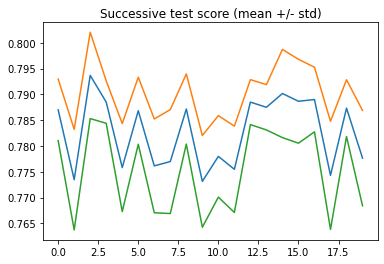

In [21]:
plt.plot(range(n_iter), optimized_clf.cv_results_['mean_test_score'])
plt.plot(range(n_iter), optimized_clf.cv_results_['mean_test_score'] + optimized_clf.cv_results_['std_test_score'])
plt.plot(range(n_iter), optimized_clf.cv_results_['mean_test_score'] - optimized_clf.cv_results_['std_test_score'])
plt.title("Successive test score (mean +/- std)")

In [23]:
# Optimmized_clf can now be used as other classifier:
# y_pred = optimised_clf.predict(X)

# Conclusion

Tout au long de ce notebook, nous avons pu observer comment les performances d'un algorithme peuvent varier en fonction de l'entraînement et des hyper-paramètres.

L'évaluation d'un modèle doit être très rigoureuse ! En effet, il est nécessaire de constamment se poser la question de la qualité de l'apprentissage du modèle : est-ce le modèle est en sur-apprentissage ? est-ce que le modèle a suffisamment appris ?
Les meilleurs modèles sont ceux qui parviennent à réaliser au mieux ce compromis entre biais et variance, autrement dit entre un modèle riche et une capacité de généralisation.